In [11]:
%matplotlib inline
import imageio as io
from os import listdir, path
import matplotlib.pyplot as plt
import numpy as np
import random
import albumentations as A


In [12]:
image_names = []
mask_names = []
IMAGE_DIR = 'train_image'

for name in listdir(path.join(IMAGE_DIR, 'original')):
    image_names.append(name)
    mask_names.append(name+'_mask.png')

images = []
masks = []
for im_n, ms_n in zip(image_names, mask_names):
    images.append(io.imread(path.join(IMAGE_DIR, 'original', im_n)))
    masks.append(io.imread(path.join(IMAGE_DIR, 'mask', ms_n)))

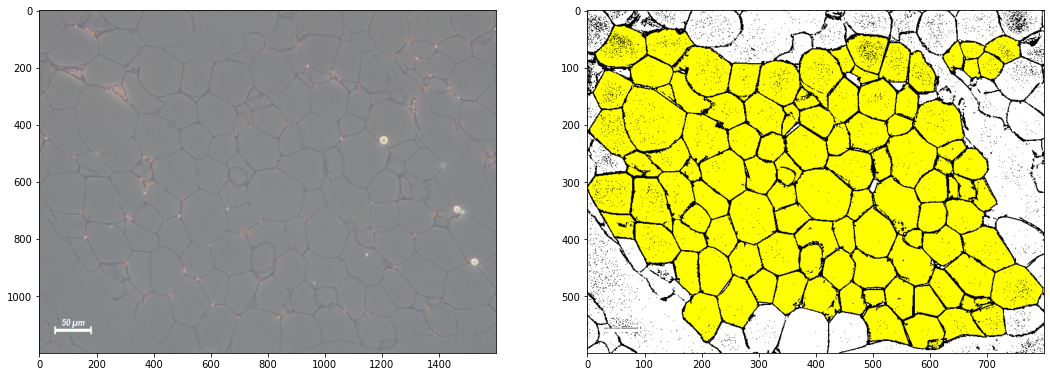

In [13]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(1,2,1)
ax.imshow(images[9])
ax = fig.add_subplot(1,2,2)
ax.imshow(masks[9])
plt.show()

In [14]:
print(images[0].shape)
print(masks[0].shape)

(1200, 1600, 3)
(600, 800, 3)


In [15]:
cut_image = []
cut_mask = []
offset = 0
target_color = [255,255,0]

for image, mask in zip(images, masks):
    for r in range(mask.shape[0]):
        if np.any(np.all(mask[r]==target_color,axis=-1)):
            row_begin = max(r - offset,0)
            break
    for r in range(mask.shape[0]-1,-1,-1):
        if np.any(np.all(mask[r]==target_color,axis=-1)):
            row_end = r + offset
            break
    for c in range(mask.shape[1]):
        if np.any(np.all(mask[:,c]==target_color,axis=-1)):
            col_begin = max(c - offset,0)
            break
    for c in range(mask.shape[1]-1,-1,-1):
        if np.any(np.all(mask[:,c]==target_color,axis=-1)):
            col_end = c + offset
            break

    cut_image.append(image[2*row_begin:2*row_end,2*col_begin:2*col_end])
    cut_mask.append(mask[row_begin:row_end,col_begin:col_end])

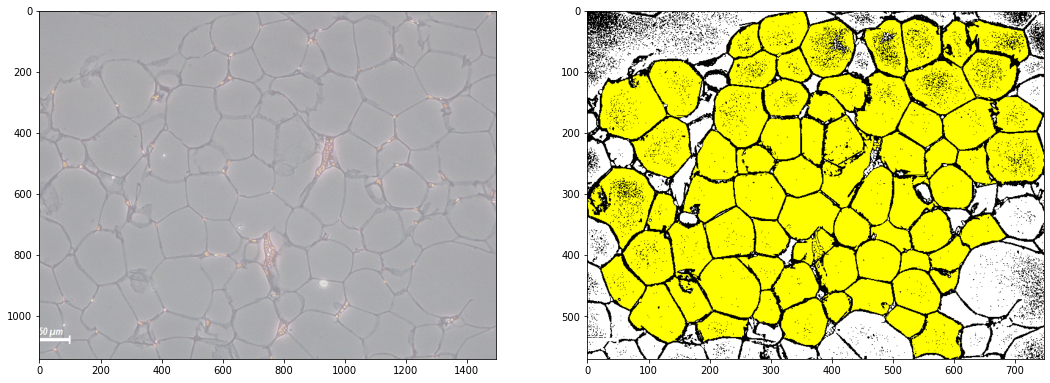

In [16]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(1,2,1)
ax.imshow(cut_image[5])
ax = fig.add_subplot(1,2,2)
ax.imshow(cut_mask[5])
plt.show()

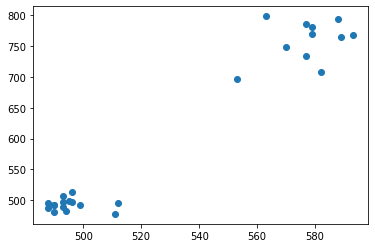

In [17]:
r_lens = [m.shape[0] for m in cut_mask]
c_lens = [m.shape[1] for m in cut_mask]
fig = plt.scatter(r_lens, c_lens)
plt.show()

In [18]:
cut_mask_bool = []
wall_color = [0,0,0]

for c_mask in cut_mask:
    booled = np.all(c_mask==wall_color,axis=-1)
    # twiced = np.repeat(np.repeat(booled, 2, axis=0),2, axis=1)
    cut_mask_bool.append(booled.astype(np.float32))

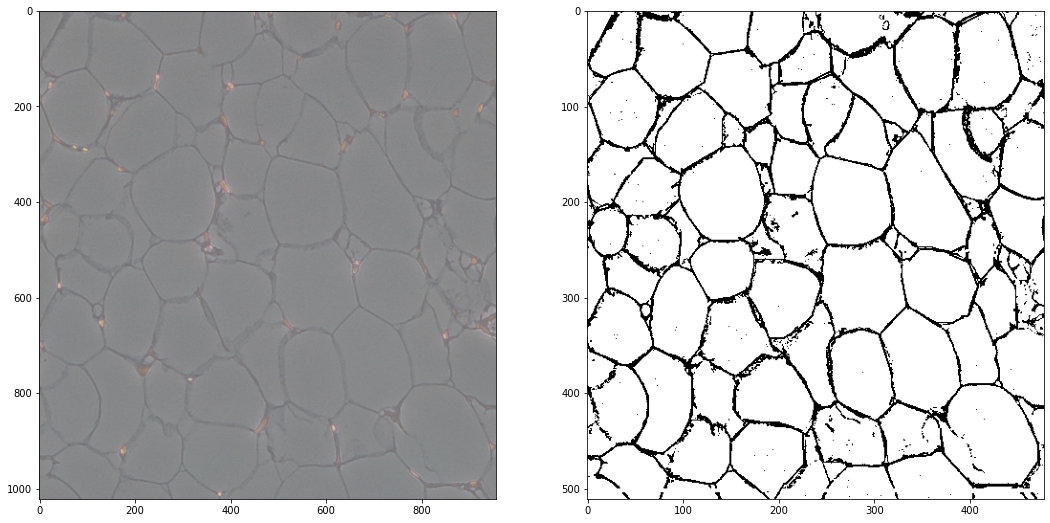

In [19]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(1,2,1)
ax.imshow(cut_image[4])
ax = fig.add_subplot(1,2,2)
ax.imshow(cut_mask_bool[4], cmap='binary')
plt.show()

In [20]:
aug = A.Compose([
    A.Resize(1100,1300),
    A.RandomCrop(200, 200, p=1),
    A.OneOf([
        A.RandomGamma((40,200),p=1),
        A.RandomBrightness(p=1),
        A.RandomContrast(p=1),
        A.RGBShift(p=1),
    ], p=0.8),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1),
])

float32
float32
True


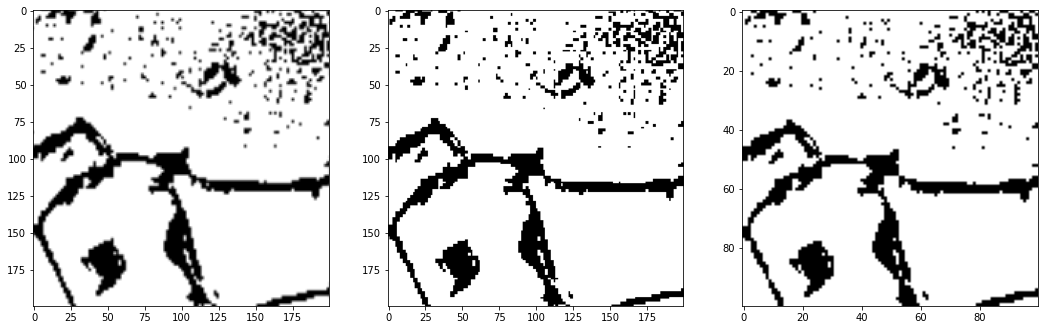

In [25]:
idx = 13
sample = cut_image[idx]
sample_mask = cut_mask_bool[idx]
distorted = aug(image=sample_mask, mask=sample_mask)
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(1,3,1)
ax.imshow(distorted['image'], cmap='binary')
print(distorted['image'].dtype)
ax = fig.add_subplot(1,3,2)
ax.imshow(distorted['mask'].astype(np.bool), cmap='binary')
print(distorted['mask'].dtype)
ax = fig.add_subplot(1,3,3)
ax.imshow(distorted['mask'][::2,::2], cmap='binary')
print(np.any(np.logical_and(distorted['image']!=0,distorted['image']!=1)))
plt.show()

In [12]:
from tqdm.notebook import trange, tqdm

X_data = np.empty((6000*len(cut_image),200,200,3),dtype=np.uint8)
Y_data = np.empty((6000*len(cut_image),100,100),dtype=np.bool)

pbar = tqdm(total=len(cut_image))
idx = 0
for img, msk_b in zip(cut_image, cut_mask_bool):
    for _ in trange(6000, leave=False):
        auged = aug(image=img, mask=msk_b)
        X_data[idx] = auged['image']
        Y_data[idx] = auged['mask'][::2,::2]
        idx += 1
    pbar.update()
print('X_data shape:{}'.format(X_data.shape))
print('X_data type:{}'.format(X_data.dtype))
print('Y_data shape:{}'.format(Y_data.shape))
print('Y_data type:{}'.format(Y_data.dtype))

X_data shape:(156000, 200, 200, 3)
X_data type:uint8
Y_data shape:(156000, 100, 100)
Y_data type:bool


X_data shape:(164296, 200, 200, 3)
X_data type:uint8
Y_data shape:(164296, 100, 100)
Y_data type:bool


In [10]:
np.savez('Adipose_dataset', 
        X_train=X_data[:-16000], 
        Y_train=Y_data[:-16000],
        X_test=X_data[-16000:],
        Y_test=Y_data[-16000:]
        )